### Modelo UMAP + GMM

In [1]:
import numpy as np
import pandas as pd
from umap import UMAP
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

In [2]:
# Importar o dataframe
df = pd.read_pickle('data/df_cleaned.pkl')

In [3]:
# Ajustes para os dados
numeric_df = df.select_dtypes(include=[np.number])
numeric_df = numeric_df.drop(['rank', 'ovr'], axis=1, errors='ignore')

In [4]:
# Normalizar
X = numeric_df.fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
# Parâmetros escolhidos por tentativa e erro
N_NEIGHBORS = 50
MIN_DIST = 0.15      

umap_3d = UMAP(
    n_components=3, 
    n_neighbors=N_NEIGHBORS,
    min_dist=MIN_DIST,
    metric='euclidean',
    n_jobs=-1
)

projection_3d = umap_3d.fit_transform(X_scaled)

In [6]:
# --- 4. PREPARAR DATAFRAME PARA O PLOTLY ---
df_viz = df.loc[numeric_df.index].copy()
df_viz['UMAP1'] = projection_3d[:, 0]
df_viz['UMAP2'] = projection_3d[:, 1]
df_viz['UMAP3'] = projection_3d[:, 2]

# --- 5. VISUALIZAÇÃO 3D ---
fig = px.scatter_3d(
    df_viz, 
    x='UMAP1', y='UMAP2', z='UMAP3',
    color='position', 
    hover_name='name',
    hover_data=['position', 'ovr', 'age'],
    title=f'UMAP 3D (n_neighbors={N_NEIGHBORS}, min_dist={MIN_DIST})',
    opacity=0.7,
    height=500
)

# Estilização Clean
fig.update_layout(
    paper_bgcolor='white',
    plot_bgcolor='white',
    font=dict(color='#2c3e50', family="Arial"),
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False),
        aspectmode='data' 
    )
)

fig.update_traces(marker=dict(size=3, line=dict(width=0)))
fig.show()

In [7]:
# Intervalo de clusters que vamos testar
n_components_range = range(2, 21)
bic_scores = []
aic_scores = []

for n in n_components_range:
    gmm_test = GaussianMixture(n_components=n, n_init=5, random_state=42)
    gmm_test.fit(projection_3d)
    
    # Armazena as métricas (quanto menor, melhor)
    bic_scores.append(gmm_test.bic(projection_3d))
    aic_scores.append(gmm_test.aic(projection_3d))

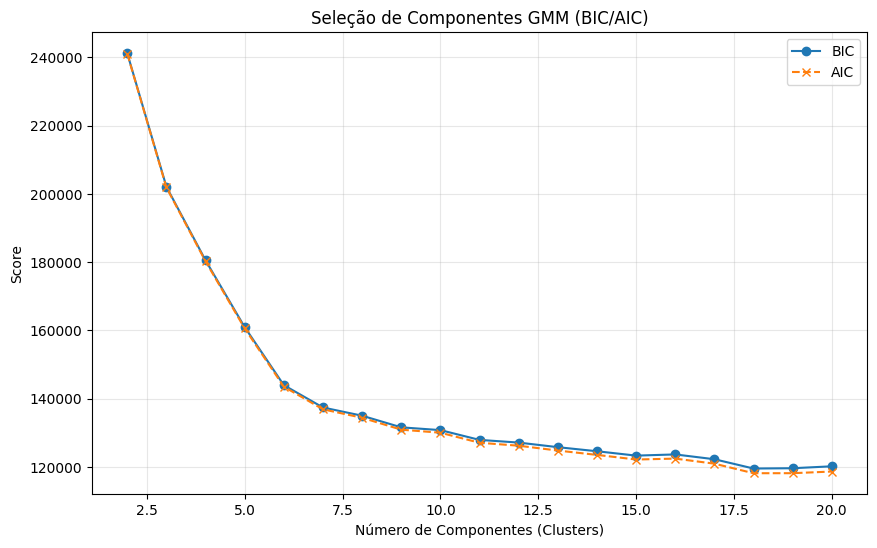

In [8]:
# Plotar o resultado para escolher via método do cotovelo
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic_scores, label='BIC', marker='o')
plt.plot(n_components_range, aic_scores, label='AIC', marker='x', linestyle='--')
plt.title('Seleção de Componentes GMM (BIC/AIC)')
plt.xlabel('Número de Componentes (Clusters)')
plt.ylabel('Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [9]:
# Treinamento do GMM..

N_COMPONENTS = 7
gmm = GaussianMixture(n_components=N_COMPONENTS, n_init=10, random_state=42)
cluster_labels = gmm.fit_predict(projection_3d)

# 3. Calcular a probabilidade de certeza
probs = gmm.predict_proba(projection_3d)
certainty = probs.max(axis=1)

df_viz['cluster_gmm'] = cluster_labels.astype(str)
df_viz['cluster_conf'] = certainty

In [10]:
# --- VISUALIZAÇÃO DOS CLUSTERS GMM ---
fig = px.scatter_3d(
    df_viz, 
    x='UMAP1', y='UMAP2', z='UMAP3',
    color='cluster_gmm', 
    hover_name='name',
    hover_data=['position', 'cluster_conf', 'ovr'],
    title=f'Clusters GMM (k={N_COMPONENTS}) sobre UMAP 3D',
    opacity=0.7,
    height=600
)

fig.update_layout(
    paper_bgcolor='white',
    plot_bgcolor='white',
    font=dict(color='#2c3e50', family="Arial"),
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False),
        aspectmode='data'
    ),
    # Legenda mais limpa
    legend_title_text='Cluster ID'
)

fig.update_traces(marker=dict(size=3, line=dict(width=0)))

fig.show()

In [11]:
atributos_disponiveis = [col for col in numeric_df if col in df_viz.columns]

# --- 2. CÁLCULO DA DOMINÂNCIA ---
cluster_means = df_viz.groupby('cluster_gmm')[atributos_disponiveis].mean()
global_means = df_viz[atributos_disponiveis].mean()
pct_diff_matrix_full = ((cluster_means - global_means) / global_means) * 100

# Ordenação dos Clusters (Numérica)
pct_diff_matrix_full.index = pct_diff_matrix_full.index.astype(int)
pct_diff_matrix_full = pct_diff_matrix_full.sort_index()
pct_diff_matrix_full.index = pct_diff_matrix_full.index.astype(str)

pct_diff_matrix_T = pct_diff_matrix_full.T.round(1)
print(f"Matriz calculada com {len(atributos_disponiveis)} atributos.")

Matriz calculada com 54 atributos.


In [12]:
# --- 2. CÁLCULO DA MATRIZ ---
cluster_means = df_viz.groupby('cluster_gmm')[atributos_disponiveis].mean()
global_means = df_viz[atributos_disponiveis].mean()
pct_diff_matrix = ((cluster_means - global_means) / global_means) * 100

# Transpor para ficar (Atributo x Cluster) e arredondar
df_report = pct_diff_matrix.T.round(1)

# Ordenar colunas (clusters) numericamente
df_report.columns = df_report.columns.astype(int)
df_report = df_report.sort_index(axis=1)

# --- 3. VISUALIZAÇÃO (HEATMAP) ---
fig = px.imshow(
    df_report,
    labels=dict(x='',y="Atributo", color="Diff (%)"),
    x=df_report.columns.astype(str), # String para o eixo X do plot
    y=df_report.index,
    text_auto=True,
    aspect="auto",
    color_continuous_scale='RdBu_r', 
    color_continuous_midpoint=0,
    range_color=[-60, 60]
)
fig.update_layout(
    title='Mapa de Calor: Dominância de Atributos por Cluster',
    height=max(600, len(atributos_disponiveis) * 25),
    width=1000,
    xaxis=dict(side="top")
)
fig.update_traces(texttemplate='%{z:.0f}%')
fig.show()

In [13]:
print('Relatório do perfil de cada cluster:\n')

for cluster in df_report.columns:

    col_data = df_report[cluster]
    
    # 2. Análise de Posições
    # Filtra o dataframe original para pegar apenas jogadores deste cluster
    mask_cluster = df_viz['cluster_gmm'] == str(cluster)
    df_cluster_atual = df_viz[mask_cluster]
    total_jogadores = len(df_cluster_atual)
    
    # Calcula % das posições
    pos_dist = df_cluster_atual['position'].value_counts(normalize=True) * 100
    
    # 3. Identificar Top 5 Fortes e Fracos (Atributos)
    top_5_fortes = col_data.sort_values(ascending=False).head(5)
    top_5_fracos = col_data.sort_values(ascending=True).head(5)
    
    # --- IMPRESSÃO ---
    print(f"Cluster {cluster} (n={total_jogadores})")
    print(f"{'-'*40}")
    
    # Imprimir Posições Principais
    print("[i] Posições:")
    # Mostra apenas as top 3 ou 4 posições para não poluir
    for pos, pct in pos_dist.head(4).items():
        print(f"       • {pos:<15} : {pct:.1f}%")
    
    # Se houver muitas outras posições pequenas, agrupa
    resto = pos_dist.iloc[4:].sum()
    if resto > 0:
        print(f"       • {'Outros':<15} : {resto:.1f}%")
        
    print("")

    # Imprimir Fortes
    print("   [+] Pontos Fortes:")
    tem_forte = False
    for attr, val in top_5_fortes.items():
        if val > 0:
            print(f"       • {attr:<20} : +{val}%")
            tem_forte = True
        else:
            if not tem_forte:
                print(f"       • (Nenhum atributo significativamente acima da média)")
            break
            
    print("")
    
    # Imprimir Fracos
    print("   [-] Pontos Fracos:")
    for attr, val in top_5_fracos.items():
        print(f"       • {attr:<20} : {val}%")
        
    print(f"\n{'='*80}\n")

Relatório do perfil de cada cluster:

Cluster 0 (n=3168)
----------------------------------------
[i] Posições:
       • CM              : 47.2%
       • CDM             : 39.4%
       • RM              : 4.6%
       • CAM             : 4.0%
       • Outros          : 4.8%

   [+] Pontos Fortes:
       • sector_midfielder    : +164.9%
       • all_around           : +136.7%
       • interceptions        : +34.6%
       • standing_tackle      : +32.1%
       • sliding_tackle       : +31.8%

   [-] Pontos Fracos:
       • offensive            : -100.0%
       • gk_reflexes          : -100.0%
       • gk_positioning       : -100.0%
       • gk_kicking           : -100.0%
       • gk_handling          : -100.0%


Cluster 1 (n=2930)
----------------------------------------
[i] Posições:
       • LM              : 28.8%
       • CAM             : 28.5%
       • RM              : 25.8%
       • CM              : 16.5%
       • Outros          : 0.4%

   [+] Pontos Fortes:
       • offensive  

In [14]:
# --- 5. IMPRIMIR MATRIZ COMPLETA (RAW) ---
print("MATRIZ COMPLETA DE DADOS (Copiável):")
pd.set_option('display.max_rows', None)
print(df_report)
pd.reset_option('display.max_rows')

MATRIZ COMPLETA DE DADOS (Copiável):
cluster_gmm             0      1      2      3      4      5      6
pac                  -4.6    8.4    4.9    2.0   -4.5  -15.6    4.1
sho                   4.3   12.0   19.2  -19.1   16.3  -38.6  -16.7
pas                   8.4    6.5   -5.3   -3.2    6.4  -20.1   -0.4
dri                   3.6    7.8    2.7   -2.7    3.4  -23.8   -1.1
def                  23.5  -19.2  -37.8   25.8  -31.0   30.8   24.6
phy                   3.3  -11.8   -1.4    5.2   -2.4    9.9    2.7
acceleration          1.4   15.7    9.8    6.6  -46.3  -13.8    9.4
sprint_speed         -0.5   12.8   10.8    7.7  -45.8   -9.1    9.7
positioning          17.3   23.0   29.0   -0.5  -82.1  -36.4    4.6
finishing            15.9   29.8   41.2  -13.6  -78.7  -38.4  -11.5
shot_power            8.3   10.2   15.7   -9.3  -19.0  -20.2   -7.6
long_shots           22.9   26.3   28.9   -9.5  -77.8  -36.7   -4.9
volleys              13.2   26.6   37.6  -11.5  -75.8  -30.0   -8.5
penalties  

In [15]:
# Gerar e exibir um dataframe com os 5 melhores de cada Cluster
cols_show = ['name', 'position', 'ovr', 'pac', 'sho', 'pas', 'dri', 'def', 'phy', 'cluster_conf']
df_viz['cluster_sort'] = df_viz['cluster_gmm'].astype(int)
df_sorted = df_viz.sort_values(by=['cluster_sort', 'ovr'], ascending=[True, False])


df_top_examples = df_sorted.groupby('cluster_sort').head(5)[cols_show + ['cluster_gmm']].reset_index(drop=True)
# Dataframe completo para os 5 melhores de cada cluster
df_top_examples.head(50)

name position  ovr  pac  sho  pas  dri  def  phy  \
0                    Rodri      CDM   90   65   80   86   84   86   85   
1          Jude Bellingham      CAM   90   80   86   83   90   78   85   
2                  Vitinha       CM   89   72   80   86   90   75   70   
3                    Pedri       CM   89   77   73   85   91   78   77   
4           Joshua Kimmich      CDM   89   72   74   89   84   83   79   
5            Mohamed Salah       RM   91   89   88   86   90   45   76   
6                 Raphinha       LM   89   91   84   85   87   53   75   
7             Lamine Yamal       RM   89   85   81   86   90   23   53   
8            Florian Wirtz      CAM   89   80   82   88   90   54   67   
9            Jamal Musiala      CAM   88   80   82   80   90   66   65   
10           Kylian Mbappé       ST   91   97   90   81   92   37   76   
11         Ousmane Dembélé       ST   90   91   88   83   93   50   69   
12          Erling Haaland       ST   90   86   91   70   80   45   88   
13              Harry Kane       ST   89   64   92   83   82   48   82   
14                Vini Jr.       LW   89   95   84   81   91   29   69   
15           Achraf Hakimi       RB   89   92   79   82   83   82   79   
16            Jules Koundé       RB   87   84   47   74   79   86   84   
17         Antonio Rüdiger       CB   86   79   55   72   70   84   86   
18  Trent Alexander-Arnold       RB   86   76   72   89   80   80   74   
19                Carvajal       RB   85   80   58   79   81   81   79   
20    Gianluigi Donnarumma       GK   89   90   83   70   90   52   87   
21                 Alisson       GK   89   86   85   86   89   56   90   
22        Thibaut Courtois       GK   89   85   89   76   90   46   88   
23               Jan Oblak       GK   88   85   90   78   87   46   86   
24             Yann Sommer       GK   87   83   82   85   89   50   87   
25         Virgil van Dijk       CB   90   73   60   72   72   90   87   
26                 Gabriel       CB   88   64   44   64   65   88   84   
27              Marquinhos       CB   87   78   56   75   74   89   80   
28          William Saliba       CB   87   77   39   68   72   87   83   
29            Jonathan Tah       CB   87   63   38   60   63   87   86   
30      Alessandro Bastoni       CB   87   74   46   75   76   88   82   
31             Nuno Mendes       LB   86   95   65   76   82   80   77   
32        Federico Dimarco       LB   85   80   78   84   82   79   77   
33      Nico Schlotterbeck       CB   85   74   60   75   73   85   82   
34          Theo Hernández       LB   84   90   76   78   83   79   83   

    cluster_conf cluster_gmm  
0       1.000000           0  
1       1.000000           0  
2       1.000000           0  
3       1.000000           0  
4       1.000000           0  
5       1.000000           1  
6       1.000000           1  
7       1.000000           1  
8       1.000000           1  
9       1.000000           1  
10      1.000000           2  
11      1.000000           2  
12      1.000000           2  
13      1.000000           2  
14      1.000000           2  
15      0.998801           3  
16      1.000000           3  
17      0.999967           3  
18      0.925524           3  
19      1.000000           3  
20      1.000000           4  
21      1.000000           4  
22      1.000000           4  
23      1.000000           4  
24      1.000000           4  
25      1.000000           5  
26      1.000000           5  
27      1.000000           5  
28      1.000000           5  
29      1.000000           5  
30      1.000000           6  
31      1.000000           6  
32      0.999998           6  
33      1.000000           6  
34      1.000000           6

In [16]:
cluster_names = {
    '0': 'Volante (CDM/CM)',
    '1': 'Atacante (ST/FW)',
    '2': 'Meia Criativo (CAM/Winger)',
    '3': 'Defensor Canhoto (LB/LCB)',
    '4': 'Goleiro (GK)',
    '5': 'Zagueiro Xerife (CB)',
    '6': 'Defensor Destro (RB/RCB)'
}


df_viz['cluster_gmm'] = df_viz['cluster_gmm'].astype(str)
df_viz['cluster_name'] = df_viz['cluster_gmm'].map(cluster_names)


color_map = {
    'Goleiro (GK)': '#F1C40F',
    'Zagueiro Xerife (CB)': '#2C3E50',         
    'Defensor Canhoto (LB/LCB)': '#2980B9',    
    'Defensor Destro (RB/RCB)': '#3498DB',     
    'Volante (CDM/CM)': '#8E44AD',             
    'Meia Criativo (CAM/Winger)': '#E67E22',   
    'Atacante (ST/FW)': '#C0392B'              
}

In [17]:

# --- 3. Plot 3D Final ---
fig = px.scatter_3d(
    df_viz, 
    x='UMAP1', y='UMAP2', z='UMAP3',
    
    color='cluster_name',
    color_discrete_map=color_map,
    
    hover_name='name',
    hover_data=['position', 'ovr', 'cluster_name'],
    
    title='Clusters no Espaço Vetorial',
    height=800, width=1100,
    opacity=0.7
)

fig.update_layout(
    paper_bgcolor='white',
    legend_title_text='Função Tática',
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False),
        aspectmode='data',
        bgcolor='#f8f9fa'
    ),
    margin=dict(t=50, l=0, r=0, b=0)
)

fig.update_traces(marker=dict(size=3, line=dict(width=0)))
fig.show()

### 📋 Identidade dos 7 Novos Clusters

  * **Cluster 0 - Volante / Meia Central (CDM/CM):**

      * O motor do time. Jogadores de meio-campo (`midfielder` +165%) com perfil `all_around` (+137%). Diferem dos criativos pela defesa forte: `interceptions` (+35%) e desarmes (+32%).

  * **Cluster 1 - Atacante Finalizador (ST/FW):**

      * A linha de frente. Grupo massivo de atacantes (`sector_forward` +460%) focados em terminar a jogada. Dominam `finishing` (+41%) e `volleys` (+38%).

  * **Cluster 2 - Meia Criativo / Ala (CAM/Winger):**

      * A classe e o drible. Jogadores de meio-campo, mas ofensivos (`offensive` +178%). Destacam-se pela `versatility` (+74%) e habilidade técnica (`skill_moves` +29%).

  * **Cluster 3 - Defensor Canhoto (LB/LCB):**

      * A raridade tática. O algoritmo isolou zagueiros e laterais (`sector_defense` +199%) que são **exclusivamente canhotos** (`preferred_foot` -100%). Essenciais para o equilíbrio da saída de bola.

  * **Cluster 4 - Goleiro (GK):**

      * Os guardiões. Stats de GK +794%. Grupo isolado.

  * **Cluster 5 - Zagueiro Xerife (Stopper CB):**

      * A força bruta. Zagueiros puros (97% CB) com a flag `defensive` explodindo (+850%). Focam apenas em destruir, sem a característica `all_around` dos outros defensores.

  * **Cluster 6 - Defensor Destro (RB/RCB):**

      * A defesa técnica destra. Laterais direitos e zagueiros que sabem jogar (`all_around` +134%). Diferenciam-se do Cluster 3 por serem destros (`preferred_foot` positivo) e do Cluster 5 por terem técnica.



### 📝 Resumo Executivo (Texto)

  * **Cluster 0 (Volante):** O equilíbrio do meio-campo. Jogadores `midfielder` (+165%) e `all_around` (+137%) que priorizam a marcação (`interceptions` +35%) e a distribuição segura de bola.
  * **Cluster 1 (Atacante):** O poder de fogo. Grupo unificado de finalizadores (`sector_forward` +460%) com foco terminal em `finishing` (+41%) e `volleys` (+38%), ignorando tarefas defensivas.
  * **Cluster 2 (Meia Criativo):** A articulação ofensiva. Meias e alas (`offensive` +178%) definidos pela técnica apurada (`versatility` +74%, `skill_moves` +29%) e capacidade de drible.
  * **Cluster 3 (Defensor Canhoto):** A peça rara. Zagueiros e laterais esquerdos (`sector_defense` +199%) isolados pela lateralidade (`preferred_foot` -100%), essenciais para a geometria da saída de bola.
  * **Cluster 4 (Goleiro):** A meta. Atributos de goleiro \~800% acima da média. Grupo isolado geometricamente.
  * **Cluster 5 (Zagueiro Xerife):** A barreira. Defensores físicos (`defensive` +850%) que abdicam da técnica `all_around` para focar puramente em destruição de jogadas e força física.
  * **Cluster 6 (Defensor Destro):** A defesa moderna. Laterais direitos e zagueiros técnicos (`all_around` +134%) que combinam forte marcação com mobilidade e apoio ao jogo.